# COGS 108 - Final Project 

# Overview

<strong>3-4 sentences summarizing your group's project </strong>

*Fill in your overview here*

# Names / ID

- Lan Wei       
- Sean Race     
- Weilun Yao    
- Shine Paek     
- Kyosuke Goto    

# Group Members IDs

- A########
- A########
- A########
- A########

# Research Question

*Fill in your research question here* (1-2 sentences)


## Background and Prior Work

*Fill in your background and prior work here*

<strong>Why is this question of interest to your group? What background information led you to your hypothesis. Why is this important?</strong>

<strong>Find some relevant prior work, and reference those sources. Even if you think you have a totally novel question, find the most similar prior work that you can and discuss how it relates to your project</strong>

<strong>2-3 paragraphs, including at least 2 reference</strong>

References (include links):
- 1)
- 2)


# Hypothesis


*Fill in your hypotheses here*


# Dataset

### Dataset Name: 
Mortality Multiple Cause Files

### Site: 
Centers for Disease Control and Prevention - National Center for Health Statistics<BR>
https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm

### Dataset Link:
2017 Dataset
&nbsp;&nbsp;&nbsp;&nbsp;
ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/mortality/mort2017us.zip
<BR>2016 Dataset
&nbsp;&nbsp;&nbsp;&nbsp;
ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/mortality/mort2016us.zip
&nbsp;&nbsp;&nbsp;&nbsp;
<BR>2015 Dataset
&nbsp;&nbsp;&nbsp;&nbsp;
ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/mortality/mort2015us.zip
<BR>2014 Dataset
&nbsp;&nbsp;&nbsp;&nbsp;
ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/mortality/mort2014us.zip
<BR>2013 Dataset
&nbsp;&nbsp;&nbsp;&nbsp;
ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Datasets/DVS/mortality/mort2013us.zip

### Number of Observations:
TOTAL:&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
13,520,719 
<BR>2017 Dataset:
&nbsp;&nbsp;&nbsp;&nbsp;
2,820,034 
<BR>2016 Dataset:
&nbsp;&nbsp;&nbsp;&nbsp;
2,749,864
<BR>2015 Dataset:
&nbsp;&nbsp;&nbsp;&nbsp;
2,718,198
<BR>2014 Dataset:
&nbsp;&nbsp;&nbsp;&nbsp;
2,631,171
<BR>2013 Dataset:
&nbsp;&nbsp;&nbsp;&nbsp;
2,601,452

### Fields:
Age<BR>
Autopsy<BR>
Cause<BR>
Day of Week<BR>
Education<BR>
Hispanic Origin<BR>
Marital Status<BR>
Method of Disposition<BR>
Month of Death<BR>
Place of Death<BR>
Place of Injury<BR>
Race<BR>
Resident Status<BR>
Sex<BR>
etc...

### Description:
These datasets are publicly available within the National Vital Statistics System provided by the Center for Disease Control and Prevention. The Morality data used provides national demographic, cause of death information. Public use file omits sensitive information such as location (state/county) and exact dates of death. Available data year ranges from 1968 to 2017. We will be analyzing the years 2013 to 2017.

Each of these dataset are detailed and contain many entries. For example, in the year 2013 alone there are about 2,600,000 deaths recorded. This means that for our project, we have more than enough data to work with. Furthermore, since this dataset has both education aspects and manner-of-death aspects (in which one of the manners is suicide), it is a good dataset for our research question.

Each data file contains tapes (rows) with fields identified by column number. Since the data from each year uses identical field location, they were able to be combined without adjustments.





# Setup

<strong>Include packages used for analysis in cell provided</strong>

*Fill in your description here*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import csv
import io
import glob
import gc


# Data Cleaning

Describe your data cleaning steps here.

<strong>What methods did you use to analyze your data? Briefly explain what steps you had to take before you were able to use the datasets you chose to answer your question of interest.
    
   - How 'clean' is the data?
   - What did you have to do to get the data into usable format?
   - What pre-processing steps that were required for your methods (for example, checking data distributions and performing any transformations that may be required)
 
</strong>

The obtained datasets have the extension ".DUSMCPUB" and are compressed using Zip. Since each of uncompressed data file was more than 1GB in size, we needed to clean/process the data files individually by years to work within the limited memory resource. In order to extract and process the data we defined several functions:

   - <strong>extractZip</strong> : Extracts specified data files from zip archive in directory    
   - <strong>read_data</strong> :  Create pandas DataFrame from single Mortality data file (.DUSMCPUB)
   - <strong>get_cdf</strong> :    Process individual data frames (by year) and output combined data frame


In [2]:
'''
    Extracts data file from zip archive in directory
    Parameter: Integer Start year, Integer End year (inclusive)
    Return Value: None
'''
def extractZip(start,end):
    for year in range(start,end+1):
        file = 'mort{}us.zip'.format(year)
        try:
            with ZipFile(file,'r') as z:
                z.extractall()
                
        except FileNotFoundError:
            print('MISSING ' + file)
        else:
            print('UNZIPPED ' + file)

In [3]:
## Extract zip files from year 2013 to 2017
#extractZip(start=2013, end=2017)

## DEBUG : Make sure data file exist for 2013-2017
#assert len(glob.glob('VS1[3-7]MORT.DUSMCPUB')) == 5

Since the pandas library does not provide a builtin function to read the column seperated data, we wrote the function 'read_data' to transform our dataset into data frames. The function converts each row (string) in the data file into a row in data frame by interpreting the values found in specific columns. StringIO was required to effeciently use memory. Data were read in as objects types because the digits in the dataset represents code/key instead of numerical value. While there were many fields in the raw dataset, for the purpose of our project we selected:            
   - Data year
   - Manner of Death
   - Sex
   - Race
   - Education Reporting Flag
   - Education 1989 Revision
   - Education 2003 Revision
   - Age Recode 52
   - Hispanic origin
              


In [4]:
'''
    Read in single CDC Mortality data file (.DUSMCPUB)
    Parameter: String filename
    Return Value: pandas DataFrame
'''
def read_data(filename):
    
    # Specify column order
    fields = ['Data year',
              'Manner of Death',
              'Sex',
              'Race',
              'Education Reporting Flag',
              'Education 1989 Revision',
              'Education 2003 Revision',
              'Age Recode 52',
              'Hispanic origin']

    out = io.StringIO()
    cw = csv.DictWriter(out,fields)
    cw.writeheader()

    # Open data file
    with open(filename,'r') as inFile:
        for line in inFile:
            
            # Specify field name and tape location
            row = {
                'Education 1989 Revision' :line[60:62],
                'Education 2003 Revision' :line[62],
                'Education Reporting Flag':line[63],
                'Sex'                     :line[68],
                'Age Recode 52'           :line[74:76],
                'Data year'               :line[101:105],
                'Manner of Death'         :line[106],
                'Race'                    :line[444:446],
                'Hispanic origin'         :line[483:486]            
              }
            cw.writerow(row)

    out.seek(0)
    return pd.read_csv(out, dtype=object)

In the function 'read_data', we were able to select which fields to read from the data file. 'read_data' is a helper function to the function 'get_cdf' where majority of data cleaning takes place. This function accepts 3 arguments: start year, end year, and (education) revision year. Each data frame corresponding to the year between end year and start year is processed as below.

The data set from CDC was mostly clean even though missing values were found for 'Manner of Death','Education 1989 Revision','Education 2003 Revision' columns. Any missing values (blank space) were replaced by NaN values so it can be interpreted. 

First we removed any entries where 'Manner of Death' was not Suicide (2) or Natural (7). In this process, missing values and irrelevant data were removed.

Next we checked if any rows were missing both 'Education 1989 Revision' and 'Education 2003 Revision' values. The results showed that the entries either contained 1989 revision code or 2003 revision values. Although we attempted to merge the categories for 1989 and 2003 revisions, this proved to be difficult because 1989 only showed the number of years of school attended, whereas 2003 was based on education levels and degrees obtained. For example, 'some college credit, but no degree' may mean any years of college and college degree may be obtained in various years.

Using the revision argument to the function, we decided to create seperate output data frames that only contain entries from either 1989 educational revision or 2003 educational revision. In each case, we removed the column for 'Education Reporting Flag' used to distinguish entries by revision and the column for the alternative revision.

Upon inspection of the data, we found that the included age ranged from 'Under 1 hour' (00) to '125 years and over' (51). First, we combined all the ages from 'under 1 hour' (00) to '4 years' (26) into 'less than 5 years old' to represent age group before K-12 education. Furthermore we felt that in our analysis, suicide before age 5 was unusual. Next, we took additional precaution by combining the eight ages groups above 90 into 'greater than 90'. This was done to protect the identities of relatively few high-aged individuals who had passed away by suicide in that specific year.

After renaming the columns for easier reference, each processed DataFrame (by year) were combined to form a combined data frame representing processed data from year 2013 to 2017.


In [5]:
'''
    Output cleaned, combined DataFrame from several CDC Mortality data file (.DUSMCPUB)
    Parameter: Integer Start year, Integer End year, Integer Education Revision year
    Return Value: pandas DataFrame
'''
def get_cdf(start, end, revision=None):

    dfs = []
    for year in range(start%100,(end+1)%100):
        file = 'VS{}MORT.DUSMCPUB'.format(year)
        print('{}    rev: {}'.format(file, revision))
        
        # Read in this year's dataset
        df = read_data(file)

        #Turn empty value into NaN
        df.replace(to_replace=r'^\s+$', value=np.nan, regex=True, inplace=True)
                
        # Show Size
        #display(df.shape)
            
        # Show Missing Value
        #display(df.isnull().sum())

        # Remove Death except Natural or Suicide
        df = df[(df['Manner of Death'] == '2') | (df['Manner of Death'] == '7')]
        
        # Check for Missing Education Data (missing both 1989 and 2003)
        no_edu = sum((df['Education 1989 Revision'].isnull()) & (df['Education 2003 Revision'].isnull()))
        assert no_edu == 0    

        # Remove Revision        
        if revision == 1989:
            df = df[(df['Education Reporting Flag'] == '0')]
            df.drop(labels=['Education 2003 Revision', 'Education Reporting Flag'], axis=1, inplace=True)
            df.rename({'Education 1989 Revision':'Education'}, axis=1, inplace=True)
        elif revision == 2003:
            df = df[(df['Education Reporting Flag'] == '1')]
            df.drop(labels=['Education 1989 Revision', 'Education Reporting Flag'], axis=1, inplace=True)
            df.rename({'Education 2003 Revision':'Education'}, axis=1, inplace=True)

        # Combine age below 5-9 years old (01~26) to 'Less than 5 years'
        age_lt5 = [ str(i).zfill(2) for i in range(1,27) ]
        df['Age Recode 52'].replace({age: '26' for age in age_lt5}, regex=True, inplace=True)

        # Combine age above 90 years old (44~51) to '90 years and over'
        age_gt90 = [ str(i) for i in range(44,52) ]
        df['Age Recode 52'].replace({age: '44' for age in age_gt90}, regex=True, inplace=True)        
    
        # Rename the Columns
        df.rename({'Data year':'Year',
            'Manner of Death':'Cause',
            'Place of Death':'Location',
            'Age Recode 52':'Age'
           }, axis=1, inplace=True)
       
        # Append data frame
        dfs.append(df)
        
        del df
        gc.collect()
        
    return pd.concat(dfs)

In [6]:
## Create DataFrame from years 2013-2017
#cdf_1989 = get_cdf(start=2013, end=2017, revision=1989)
#cdf_2003 = get_cdf(start=2013, end=2017, revision=2003)

In [7]:
## Size of Data and Missing Values by Column
#print('Revision 2003')
#display(cdf_2003.shape)
#display(cdf_2003.isnull().sum())
#display(cdf_2003.head(n=5))

#print('Revision 1989')
#display(cdf_1989.shape)
#display(cdf_1989.isnull().sum())
#display(cdf_1989.head(n=5))

Comparing the size of data using 2003 Education Revision and size of data using 1989 Education Revision,  we discovered that the later was less than 5% of the total. Therefore we decided it was safe to not include the entries using 1989 Education Revision.

In [8]:
#print('Ratio by Educational Revision')
#display(cdf_1989.shape[0]/(cdf_1989.shape[0] + cdf_2003.shape[0]))

In [9]:
## Dictionary mapping CODE and MEANING

# Manner of Death
cause_dict = {  '1': 'Accident',
                '2': 'Suicide',
                '3': 'Homicide',
                '4': 'Pending Investigation',
                '5': 'Could not determine',
                '6': 'Self-Inflicted',
                '7': 'Natural' }


# Education (2003 revision)
edu_dict = { '1': '8th grade or less',
             '2': '9-12th grade, no diploma',
             '3': 'high school graduate or GED completed',
             '4': 'some college credit, but no degree',
             '5': 'Associate degree',
             '6': "Bachelor's degree",
             '7': "Master's degree",
             '8': 'Doctorate or Professional degree',
             '9': 'Unknown' }


# Age Recode 52
age_dict = { '26':'Less than 5 years',
             '27':'5 - 9 years',
             '28':'10 - 14 years',
             '29':'15 - 19 years',
             '30':'20 - 24 years',
             '31':'25 - 29 years',
             '32':'30 - 34 years',
             '33':'35 - 39 years',
             '34':'40 - 44 years',
             '35':'45 - 49 years',
             '36':'50 - 54 years',
             '37':'55 - 59 years',
             '38':'60 - 64 years',
             '39':'65 - 69 years',
             '40':'70 - 74 years',
             '41':'75 - 79 years',
             '42':'80 - 84 years',
             '43':'85 - 89 years',
             '44':'90 years and over',
             '52':'Age not stated'}


# Race
race_dict = { '01':'White',
              '02':'Black',
              '03':'American Indian (Includes Aleuts and Eskimos)',
              '04':'Chinese',
              '05':'Japanese',
              '06':'Hawaiian (includes Part-Hawaiian)',
              '07':'Filipino',
              '08':'Other Asian or Pacific Islander',
              '18':'Asian Indian',
              '28':'Korean',
              '38':'Samoan',
              '48':'Vietnamese',
              '58':'Guamanian',
              '68':'Other Asian or Pacific Islander',
              '78':'Combined other Asian or Pacific Islander',
              '00':'Other races' }


In [10]:
## Mapped Code to actual meanings
#cdf_2003['Cause'] = cdf_2003['Cause'].map(cause_dict)
#cdf_2003['Education'] = cdf_2003['Education'].map(edu_dict)
#cdf_2003['Age'] = cdf_2003['Age'].map(age_dict)
#cdf_2003['Race'] = cdf_2003['Race'].map(race_dict)

#display(cdf_2003.head(n=5))

In [11]:
## Write processed data to file
#cdf_2003.to_csv('MORT_13_17.csv', index=False)

## Delete DataFrame
#del cdf_2003
#del cdf_1989

# Data Visualization

In [12]:
# Read CSV
cdf = pd.read_csv('MORT_13_17.csv', dtype=object)
cdf.head()

,Year,Cause,Sex,Race,Education,Age,Hispanic origin
0,2013,Natural,F,White,"9-12th grade, no diploma",75 - 79 years,100
1,2013,Natural,F,Black,"9-12th grade, no diploma",85 - 89 years,100
2,2013,Natural,M,White,"some college credit, but no degree",90 years and over,100
3,2013,Natural,F,White,8th grade or less,85 - 89 years,100
4,2013,Natural,F,White,8th grade or less,90 years and over,100


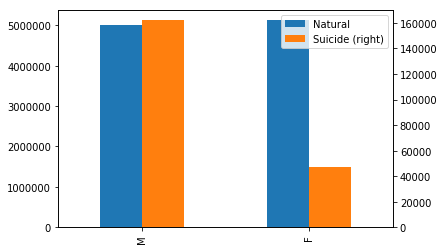

In [13]:
#suicide deaths vs natural deaths by gender
#get value_counts of both Natural and Suicide deaths
NG = cdf[cdf['Cause'] == 'Natural']['Sex'].value_counts()
SG = cdf[cdf['Cause'] == 'Suicide']['Sex'].value_counts()
#debugging
"""
print('Natural Deaths by Gender:')
print(NG)
print()
print('Suicide Deaths by Gender:')
print(SG)
"""
#convert value counts to list
NGL = NG.tolist()
SGL = SG.tolist()
#combine value counts into new dataframe
CombinedGenderData = pd.DataFrame({'Natural': [NGL[1], NGL[0]],'Suicide': [SGL[0], SGL[1]]},index=['M','F'])
#calibrate natural and suicide deaths each based on their own y-axis
CombinedGenderData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

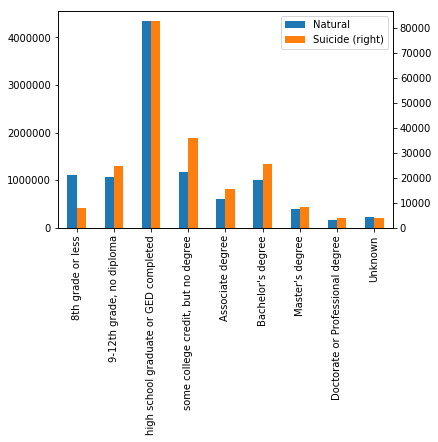

In [14]:
#suicide deaths vs natural deaths by education
#get value_counts of both Natural and Suicide deaths by education
NE = cdf[cdf['Cause'] == 'Natural']['Education'].value_counts().reindex(list(edu_dict.values()))
SE = cdf[cdf['Cause'] == 'Suicide']['Education'].value_counts().reindex(list(edu_dict.values()))
#debugging
"""
print('Natural Deaths by Education:')
print(NE)
print()
print('Suicide Deaths by Education:')
print(SE)
"""
#convert value counts to list
NEL = NE.tolist()
SEL = SE.tolist()
#combine value counts into new dataframe
CombinedEducationData = pd.DataFrame({'Natural': NEL,'Suicide': SEL},index=list(edu_dict.values()))
#calibrate natural and suicide deaths each based on their own y-axis
CombinedEducationData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

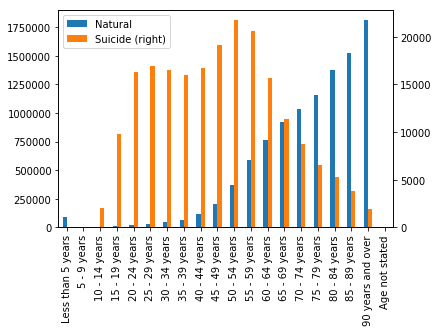

In [15]:
#suicide deaths vs natural deaths by age
#cdf[cdf['Cause'] == 'Natural']['Age'].value_counts().reindex(list(age_dict.values())).plot.bar()
#get value_counts of both Natural and Suicide deaths by age
NA = cdf[cdf['Cause'] == 'Natural']['Age'].value_counts().reindex(list(age_dict.values()))
SA = cdf[cdf['Cause'] == 'Suicide']['Age'].value_counts().reindex(list(age_dict.values()))
#debugging
"""
print('Natural Deaths by Age:')
print(NA)
print()
print('Suicide Deaths by Age:')
print(SA)
"""
#convert value counts to list
NAL = NA.tolist()
SAL = SA.tolist()
#combine value counts into new dataframe
CombinedAgeData = pd.DataFrame({'Natural': NAL,'Suicide': SAL},index=list(age_dict.values()))
#calibrate natural and suicide deaths each based on their own y-axis
CombinedAgeData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

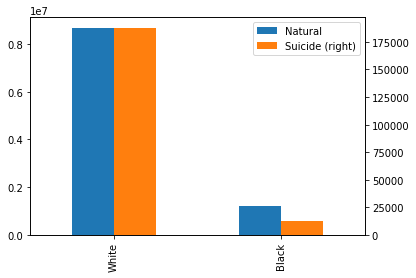

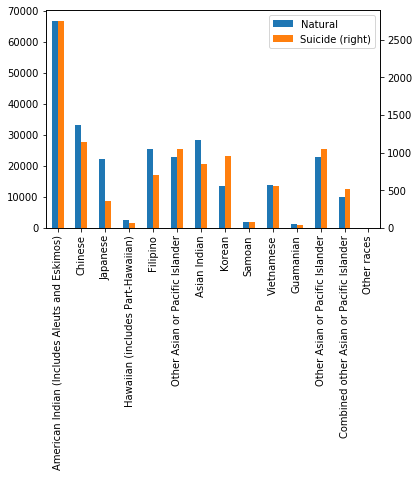

In [16]:
#suicide deaths vs natural deaths by race
#cdf[cdf['Cause'] == 'Natural']['Race'].value_counts().reindex(list(race_dict.values())).plot.bar()
#get value_counts of both Natural and Suicide deaths by age
NR = cdf[cdf['Cause'] == 'Natural']['Race'].value_counts().reindex(list(race_dict.values()))
SR = cdf[cdf['Cause'] == 'Suicide']['Race'].value_counts().reindex(list(race_dict.values()))
#debugging
"""
print('Natural Deaths by Race:')
print(N)
print()
print('Suicide Deaths by Race:')
print(S)
"""
#convert value counts to list
NRL = NR.tolist()
SRL = SR.tolist()
#create lists for other races other than black or white
NOther = NRL[2:]
SOther = SRL[2:]
otherIndex = list(race_dict.values())[2:]
#combine value counts into new dataframe
CombinedRaceWBData = pd.DataFrame({'Natural': [NRL[0],NRL[1]],'Suicide': [SRL[0],SRL[1]]},index=['White','Black'])
CombinedRaceOtherData = pd.DataFrame({'Natural': NOther,'Suicide': SOther},index=otherIndex)
#calibrate natural and suicide deaths each based on their own y-axis
CombinedRaceWBData.plot(kind='bar',secondary_y= 'Suicide')
CombinedRaceOtherData.plot(kind='bar',secondary_y= 'Suicide')
plt.show()

In [17]:
"""
IMPORTANT NOTE:
Since we now have data from 2013-17 thanks to Kyo, we can also
do some sort of visualization in trendline, etc.
Stuff that incorporates spanning over different years
"""

'\nIMPORTANT NOTE:\nSince we now have data from 2013-17 thanks to Kyo, we can also\ndo some sort of visualization in trendline, etc.\nStuff that incorporates spanning over different years\n'

Education,8th grade or less,"9-12th grade, no diploma",high school graduate or GED completed,"some college credit, but no degree",Associate degree,Bachelor's degree,Master's degree,Doctorate or Professional degree,Unknown
Year,,,,,,,,,
2013,1426,4037,14047,6103,2511,4252,1360,710,727
2014,1579,4622,15356,6726,2857,4754,1618,735,776
2015,1606,5091,16853,7423,3259,5256,1754,864,1210
2016,1651,5397,17745,7741,3358,5461,1872,861,698
2017,1727,5712,18822,8142,3467,5788,1852,915,756


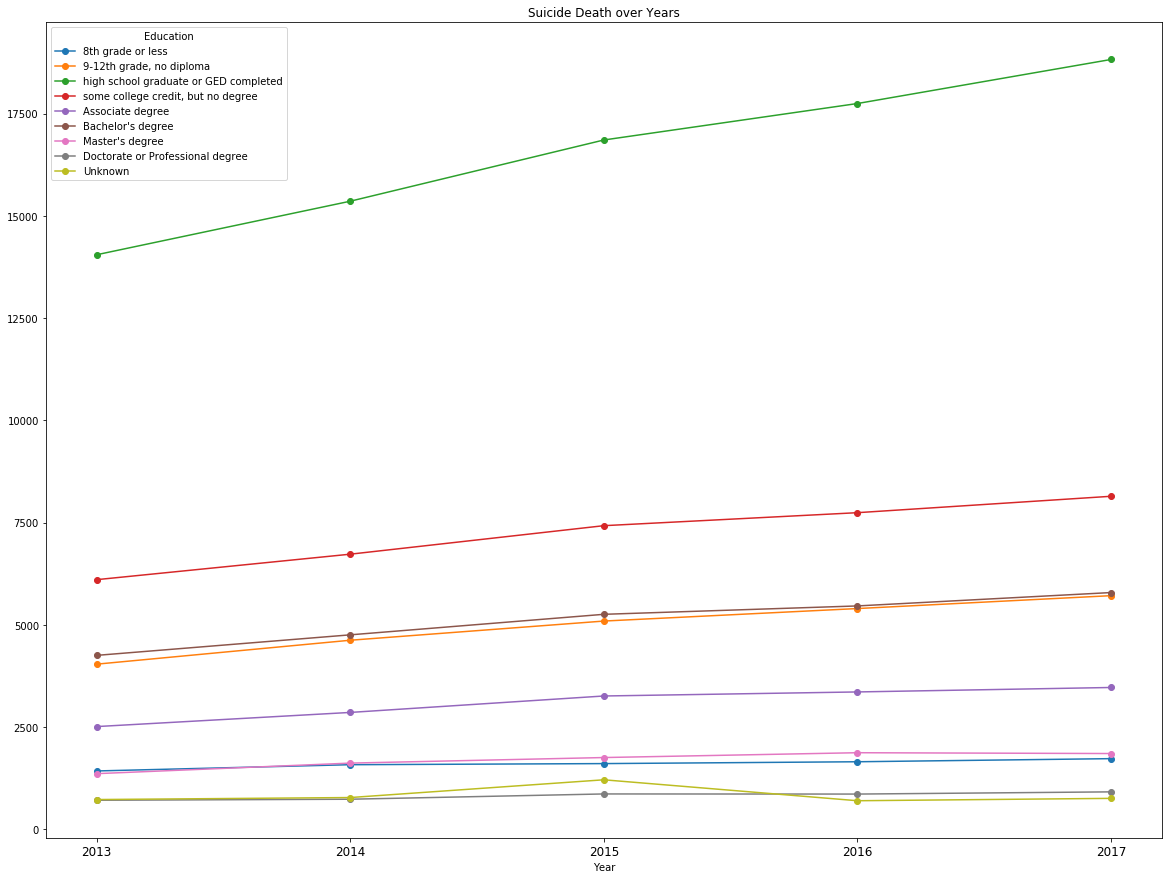

Education,8th grade or less,"9-12th grade, no diploma",high school graduate or GED completed,"some college credit, but no degree",Associate degree,Bachelor's degree,Master's degree,Doctorate or Professional degree,Unknown
Year,,,,,,,,,
2013,213008,192411,756622,198592,97463,165572,64463,26102,27506
2014,219909,206618,819163,217943,111545,182780,72978,28493,28529
2015,220985,212259,852233,228920,121047,198988,80026,31404,96824
2016,232637,234696,942777,257075,135341,222957,92051,36584,38390
2017,229499,235307,975720,270170,142383,235788,98245,39187,37160


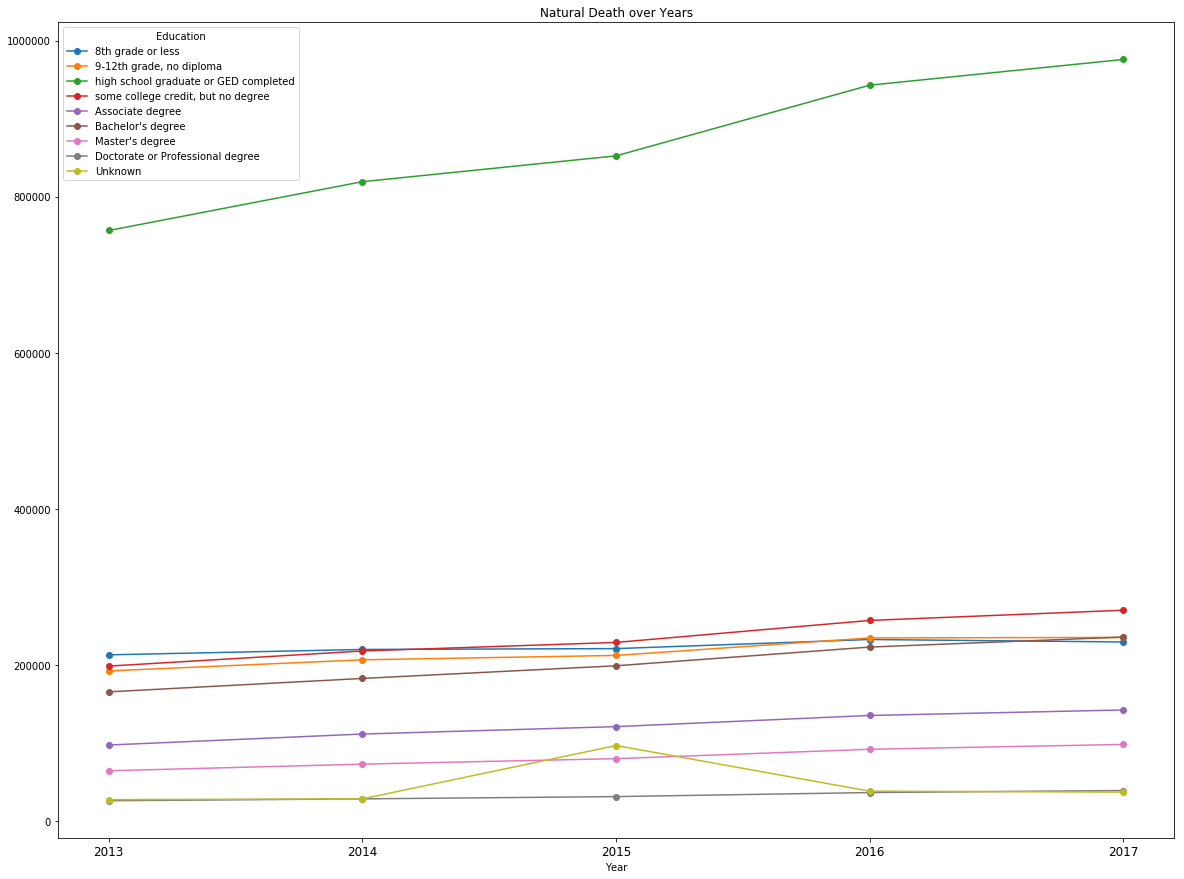

In [18]:
# Suicide Death over Years
df_s = cdf[cdf['Cause'] == 'Suicide'].groupby([cdf['Year'],cdf['Education']]).size()
df_s = df_s.unstack()[list(edu_dict.values())]
display(df_s)
df_s.plot(linestyle='-', 
          marker='o',
          figsize=(20,15),
          title='Suicide Death over Years')
plt.xticks(list(range(len(df_s.index))), df_s.index, fontsize=12)
plt.show()


# Natural Death over Years
df_s = cdf[cdf['Cause'] == 'Natural'].groupby([cdf['Year'],cdf['Education']]).size()
df_s = df_s.unstack()[list(edu_dict.values())]
display(df_s)
df_s.plot(linestyle='-', 
          marker='o',
          figsize=(20,15),
          title='Natural Death over Years')
plt.xticks(list(range(len(df_s.index))), df_s.index, fontsize=12)
plt.show()


# Data Analysis & Results

Include cells that describe the steps in your data analysis.

<strong>
EDA
   
   - What distributions do your variables take?
   - Are there any outliers?
   - Relationship between variables?
   
   
Analysis

   - What approaches did you use? Why?
   - What were the results?
   - What were your interpretation of these findings?
    
There must be AT LEAST THREE appropriate data visualizations throughout these sections. Each visualization must include an interpretation of what is displayed AND what should be learned from that visualization. Be sure that the appropriate type of visualization is generated given the data that you have, axes are all labeled, and the visualizations clearly communicate the point you're trying to make.
</strong>

In [19]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

In [20]:
#Ratio for natural deaths : Gender
nMale = NG[1]/(NG[1]+NG[0])
nFemale = NG[0]/(NG[1]+NG[0])
print('The ratio of Male to Female for Natural deaths is: Male ' + str(nMale*100)
     + ' to Female ' + str(nFemale*100))
#Ratio for suicidal deaths : Gender
sMale = SG[0]/(SG[1]+SG[0])
sFemale = SG[1]/(SG[1]+SG[0])
print('The ratio of Male to Female for Suicidal deaths is: Male ' + str(sMale*100)
     + ' to Female ' + str(sFemale*100))

The ratio of Male to Female for Natural deaths is: Male 49.3556897224 to Female 50.6443102776
The ratio of Male to Female for Suicidal deaths is: Male 77.4304577591 to Female 22.5695422409


In [21]:
#Mean of Age for Natural Deaths

#create natural death age dictionary from age range values and descriptions
nAgeDict = dict(zip(list(age_dict.values()), NA))

#get the mean value in the dictionary
nMeanPos = 0
for i in NA:
    nMeanPos = nMeanPos + i
nMeanPos = nMeanPos/2

#get the key(description) for the mean age range
nSum = 0
nMeanAge = ""
for key,value in nAgeDict.items():
    nSum = nSum + value
    if nSum > nMeanPos:
        break
    nMeanAge = key
print('The mean of ages for natural deaths is : ' + nMeanAge)
print()
#Mean of Age for Suicidal Deaths

#create suicidal death age dictionary from age range values and descriptions
sAgeDict = dict(zip(list(age_dict.values()), SA))

#delete first entry because first value is NaN
del sAgeDict['Less than 5 years']

#get the mean value in the dictionary
sMeanPos = 0
for key,value in sAgeDict.items():
    sMeanPos = sMeanPos + value
sMeanPos = sMeanPos/2

#get the key(description) for the mean age range
sSum = 0
sMeanAge = ""
for key,value in sAgeDict.items():
    sSum = sSum + value
    if sSum > sMeanPos:
        break
    sMeanAge = key
print('The mean of ages for suicidal deaths is : ' + sMeanAge)

The mean of ages for natural deaths is : 70 - 74 years

The mean of ages for suicidal deaths is : 40 - 44 years


In [22]:
#Mean of Education for Natural Deaths

#create natural death education dictionary from education values and descriptions
nEduDict = dict(zip(list(edu_dict.values()), NE))

#get the mean value in the dictionary
nMeanPos = 0
for i in NA:
    nMeanPos = nMeanPos + i
nMeanPos = nMeanPos/2

#get the key(description) for the mean age range
nSum = 0
nMeanEdu = ""
for key,value in nEduDict.items():
    nSum = nSum + value
    if nSum > nMeanPos:
        break
    nMeanEdu = key
print('The mean of education for natural deaths is : ' + nMeanEdu)
print()
#Mean of Education for Suicidal Deaths

#create suicidal death education dictionary from education values and descriptions
sEduDict = dict(zip(list(edu_dict.values()), SE))

#get the mean value in the dictionary
sMeanPos = 0
for key,value in sEduDict.items():
    sMeanPos = sMeanPos + value
sMeanPos = sMeanPos/2

#get the key(description) for the mean age range
sSum = 0
sMeanEdu = ""
for key,value in sEduDict.items():
    sSum = sSum + value
    if sSum > sMeanPos:
        break
    sMeanEdu = key
print('The mean of education for suicidal deaths is : ' + sMeanEdu)


"""IMPORTANT NOTE: in analyzation we can use this to say that even though this 
seems to show that there is no difference, this is probably because the majority
of people are high school graduates. Therefore we need another analyzation method,
which we will do later (I was thinking of calculating the mean of differences in ratio
for natural deaths vs suicidal deaths for people who have education above 8th grade.
Then we calculate the distribution/etc. similar to HW4 and see if the difference is 
significant or not. In addition we can then do something similar to the analyzation 
in homework A4, where we split by gender <aka is the difference in suicidal education 
data due to gender>

I think this is probably the best we can do given the time we have. Also, note that
these are some of the questions in the final project assignment, which we should
probably do also:

What distributions?
Outliers?
Relationship between variables?  (This kind of overlaps with what I described above
so yeah... we can be flexible on how to answer these questions)
)"""

The mean of education for natural deaths is : 9-12th grade, no diploma

The mean of education for suicidal deaths is : 9-12th grade, no diploma


'IMPORTANT NOTE: in analyzation we can use this to say that even though this \nseems to show that there is no difference, this is probably because the majority\nof people are high school graduates. Therefore we need another analyzation method,\nwhich we will do later (I was thinking of calculating the mean of differences in ratio\nfor natural deaths vs suicidal deaths for people who have education above 8th grade.\nThen we calculate the distribution/etc. similar to HW4 and see if the difference is \nsignificant or not. In addition we can then do something similar to the analyzation \nin homework A4, where we split by gender <aka is the difference in suicidal education \ndata due to gender>\n\nI think this is probably the best we can do given the time we have. Also, note that\nthese are some of the questions in the final project assignment, which we should\nprobably do also:\n\nWhat distributions?\nOutliers?\nRelationship between variables?  (This kind of overlaps with what I described 

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*
<BR>
<BR>
<strong>
Briefly acknowledge and address any potential issues of ethics and privacy for the proposed project. In particular:
    
- Did you have permission to use this data, for this purpose?  
- Are there privacy concerns regarding your datasets that you need to deal with, and/or terms of use that you need to comply with?
- Are there potential biases in your dataset(s), in terms of who is composes, and how it was collected, that may be problematic in terms of it allowing for equitable analysis? (For example, does your data exclude particular populations, or is it likely to reflect particular human biases in a way that could be a problem?)
- Are there any other issues related to your topic area, data, and/or analyses that are potentially prolematic in terms of data privacy and equitable impact?  
- How did you handle issues you identified?
(1 - 2 Paragraphs)
</strong>



# Conclusion & Discussion

*Fill in your discussion information here*

<strong>
Discuss your project. Summarize your data and question. Briefly describe your analysis. Summarize your results and conclusions. Be sure to mention any limitation of your project. Discuss the impact of this work on society.

(2-3 paragraph)
</strong>